# Variational Autoencoders (VAE)

VAE is made up of two sub-networks, the encoder and decoder. The encoder instead of compressing the input data to a fixed latent vector in the latent space, turns the input image into two parameters of statistical distributions, the mean $\mu$ which represent the most likely position of the image in the latent space and the standard deviation $\sigma$ which represent the size of the circular area around the position where the image could be. A random latent vector $z$ is then sampled from a latent normal distribution $P_{model}(z)$ from the encoder in each forward pass. The decoder then pick the sampled $z$ (a multivariate normal distribution) and tries to reconstructe $z$ as close as possible to the original input data. 


Let’s use $x$ as the vector representing the set of all observed variables. We assumed to be sample from an unknown underlying process, whose true (probability) distribution $P^{*}(x)$ is unknown. We chose a model $P(x)$ to approximate the unknow underlying process and the true distribution of the data $P^{*}(x)$ 
$$x \sim P(x) \approx P^{*}(x)$$


Approximating the conditional density of the latent variable given observed variable $P(z|x)$ is intractable. So we pick a $Q(z|x)$  to estimate $P(z|x)$  with the intention of making $Q(z|x)$ as close as possible to the true posterior $P(z|x)$. In this case $Q(z|x)$ is taking to be a Gaussian distribution


$P(x)$ the marginal likelihood

$Q(z|x)=encoder$

$P(x|z)=decoder$


**Reparameterizing the Sampling layer**

Sampling $z$ directly from $z \sim \mathcal{N}(0,1)$ creates a bottleneck since gradients cannot flow back through a random sampling operation we cannot directly backpropagate gradients through the random variable z. In order to allow gradients to flow during backpropagation instead of directly sampling $z$ from the encoder output, we use a **Reparameterization trick** in which $z$ is approximated by


$$z=\mu +\sigma \odot \epsilon  $$ where $$\epsilon \sim \mathcal{N}(0,1)$$

Instead of using the variance directly we the **log-var vector**

$$log(\sigma ^2) =2 log(\sigma)$$
$$ \sigma=exp^{\frac{log(\sigma^2)}{2}}$$
so $z$ becomes 

$$z=\mu +exp^{\frac{log(\sigma^2)}{2}} \odot \epsilon  $$ 

Because $\epsilon$ (random noise) is random process it ensures that points in the neighborhood where you encode the input image decode something similar to the imput image, thus ensuring meanful continuous distribution. Points in the neighborhood will decode to highly similar images 

![](./images/gan1.jpg)

# LOSS
 Using a loss function we want to know the amount of information lost when we go from $x$ to $z$ then to $\acute{x}$.VAE is trained via two losses, the **rconstruction loss** which measures how effective the decoder has learned to
reconstruct $x$ given the latent representation $z$ and **regularization term**

Loss= rconstruction loss  +   regularization term

$$P(𝑥, 𝑧) = P(𝑥 |𝑧) P (𝑧) = P (𝑧|𝑥) P(𝑥)$$

Applying bayes' Rule

$$P(x)=\frac{P(x|z)P(z)}{P(z|x)}$$

where $P(x|z)$ is computed using the decoder, $P(z)$ is the prior  latent vector distribution assumed to be a gaussian.
Computing the true posterior $P(z|x)$ is intractable so we train another network called encoder $Q(z|x)$ to approximates the true but intractable posterior $P(z|x)$

$$ Q(z|x) \approx P(z|x)$$
$$P(x)=\frac{P(x|z)P(z)}{P(z|x)}$$

Multiplying both  top and bottom by $Q(z|x)$ we get
$$ P(x)=log \ \frac{P(x|z)P(z)}{P(z|x)} = \frac{P(x|z)P(z) Q(z|x)}{P(z|x)Q(z|x)}$$

$$log \ P(x)=log \ \frac{P(x|z)P(z)}{P(z|x)} = log \ \frac{P(x|z)P(z) Q(z|x)}{P(z|x)Q(z|x)}$$



$$log \ P(x) =log P(x|z) - \ log \frac{Q(z|x)}{P(z)} +  \ log \frac{Q(z|x)}{P(z|x)} $$
**NOTE:**  $ log \ P(x)=E_{z \sim Q(z|x)}log \ P(x)$
$$log \ P(x) =E_{z \sim Q(z|x)} \left[ log P(x|z) \right] - E_{z \sim Q(z|x)} \left[ \ log \frac{Q(z|x)}{P(z)}\right] +  E_{z \sim Q(z|x)} \left[\ log \frac{Q(z|x)}{P(z|x)} \right]$$


$$log \ P(x) =E_{z \sim Q(z|x)} \left[ log P(x|z) \right] - D_{KL}(Q(z|x)||P(z)+ \ D_{KL}(Q(z|x)||P(z|x)  $$


$E_{z \sim Q(z|x)} \left[ log P(x|z) \right] $ is the data reconstruction error, $D_{KL}(Q(z|x)||P(z)$ is the KL divergence between the encoder network (the latent vector $z$ condition on the input $x$) and the prior and samples nwhich we assumed to be gaussian$z$  .


$ D_{KL}(Q(z|x)||P(z|x) $ is the KL divergence between the encoder and posterior of decoder. Because $P(z|x)$ is intractable so we drop 

$ D_{KL}(Q(z|x)||P(z|x)$ and since $KL \ge 0$, dropping $ D_{KL}(Q(z|x)||P(z|x) $  gives a lower bound on the data likelihood.

$$log \ P(x) \ge E_{z \sim Q(z|x)} \left[ log P(x|z) \right] - D_{KL}(Q(z|x)||P(z) $$


From [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence)
A special case, and a common quantity in variational inference, is the relative entropy between a diagonal multivariate normal, and a standard normal distribution (with zero mean and unit variance):

$$D_{kL}(N(\mu_i,\sigma_i)||N(0,\mathbb{1})=\frac{1}{2}\sum_i^{n}(1+\sigma^2-\mu^{2}-In(\sigma^{2}))$$

so in this tutorial 

**Loss=Binary cross entropy +$\frac{1}{2}\sum_i^{n}(1+\sigma^2-\mu^{2}-In(\sigma^{2}))$**


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras as K
import tensorflow as tf
from tensorflow.keras.models import Model
plt.rcParams['image.cmap']='gray'

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape


((60000, 28, 28), (10000, 28, 28))

In [3]:
x_train=x_train.reshape(-1,28,28,1)
x_test=x_test.reshape(-1,28,28,1)


In [4]:
latent_dim=64

In [5]:
class VAE(K.models.Model):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim=latent_dim
        self.encoder=K.models.Sequential([ 
                          K.layers.InputLayer(input_shape=(28, 28, 1)),
                          K.layers.Conv2D(72,kernel_size=2,padding='same',activation='relu'),
                          K.layers.Conv2D(64,kernel_size=2,strides=2,padding='same',activation='relu'),
                          K.layers.Conv2D(10,kernel_size=2,strides=2,padding='same',activation='relu'),
                          K.layers.Flatten(),
                          K.layers.Dense(70,activation='relu')
                          ])
        self.z_mean=K.layers.Dense(self.latent_dim,name='z_mean')
        self.z_log_var=K.layers.Dense(self.latent_dim,name='z_log_var')
        
        self.decoder=K.models.Sequential([
                          K.layers.InputLayer(input_shape=(self.latent_dim)),
                          K.layers.Dense(units=7*7*10,activation='relu'),
                          K.layers.Reshape(target_shape=( 7, 7, 10)),
                          K.layers.Conv2DTranspose(10,kernel_size=2,strides=2,padding='same',activation='relu'),
                          K.layers.Conv2DTranspose(64,kernel_size=2,strides=2,padding='same',activation='relu'),
                          K.layers.Conv2DTranspose(72,kernel_size=2,padding='same',activation='relu'),
                         K.layers.Conv2DTranspose(1,1,padding='same',activation='sigmoid')   
                        ])
        self.total_loss_tracker=K.metrics.Mean(name='total_loss')
    
    def Reparameterization(self,x):
        z_mean=self.z_mean(x)
        z_log_var=self.z_log_var(x)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean,z_log_var,z_mean + tf.exp(0.5 * z_log_var) * epsilon

    @property
    def metrics(self):
        return [
            self.total_loss_tracker
        ]
        
    def train_step(self,data):
        with tf.GradientTape() as tape:
            x=self.encoder(data)
            z_mean,z_log_var,latent_vector=self.Reparameterization(x)
            decoded_imgs=self.decoder(latent_vector)
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            #decoded_loss=K.losses.mean_squared_error(data,decoded_imgs)
            decoded_loss=tf.reduce_mean(
                tf.reduce_sum(K.losses.binary_crossentropy(data, decoded_imgs), axis=(1, 2)))
            total_loss=decoded_loss+kl_loss
        grads=tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {'loss':self.total_loss_tracker.result()}
            
   

In [6]:
K.backend.clear_session()

In [7]:
vae1=VAE(latent_dim=latent_dim)

In [8]:
optimizer = tf.keras.optimizers.Adam()
vae1.compile(optimizer)

In [9]:
vae1.fit(x_train, epochs=20,batch_size=100)

Epoch 1/20
600/600 [==============================] - 219s 363ms/step - loss: 340.8910
Epoch 2/20
600/600 [==============================] - 206s 344ms/step - loss: 236.7808
Epoch 3/20
600/600 [==============================] - 204s 341ms/step - loss: 228.9292
Epoch 4/20
600/600 [==============================] - 203s 339ms/step - loss: 225.6666
Epoch 5/20
600/600 [==============================] - 202s 336ms/step - loss: 223.6172
Epoch 6/20
600/600 [==============================] - 202s 336ms/step - loss: 222.3537
Epoch 7/20
600/600 [==============================] - 204s 341ms/step - loss: 220.7224
Epoch 8/20
600/600 [==============================] - 207s 345ms/step - loss: 218.7815
Epoch 9/20
600/600 [==============================] - 202s 337ms/step - loss: 218.6388
Epoch 10/20
600/600 [==============================] - 206s 344ms/step - loss: 218.2490
Epoch 11/20
600/600 [==============================] - 205s 342ms/step - loss: 216.6559
Epoch 12/20
600/600 [====================

In [10]:
x=vae1.encoder.predict(x_test)
z_mu,z_sigma,encoded_imgs=vae1.Reparameterization(x)
decoded_imgs=vae1.decoder.predict(encoded_imgs)

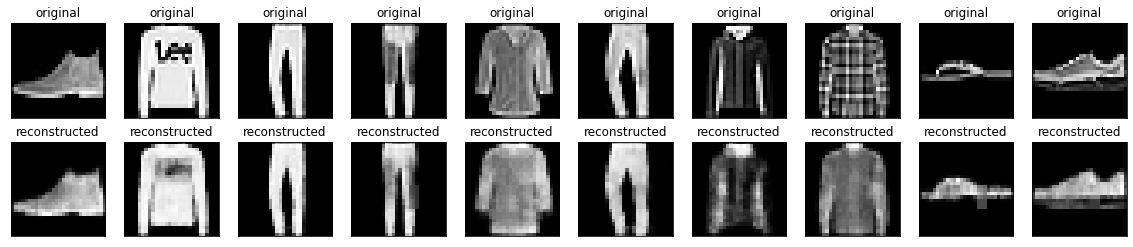

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

<b>References </b>

-  [Evidence lower bound](https://en.wikipedia.org/wiki/Evidence_lower_bound)
-  [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence)
- [ Variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
- [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
- [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
